# **Image Segmentation Using Linear Programming**
**Team members:**
- Manasa Maganti
- Arantza Garcia Delfin
- Navya Singhal
- Cole Brown

# **Objective**
Evaluate the feasibility of implementing image segmentation using the max flow/min cut theorem and linear programming, providing insights and recommendations for its integration into our product development.

Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0x9c3718d3
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1497 rows and 6427 columns
Presolve time: 0.03s
Presolved: 14887 rows, 58599 columns, 117049 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.920e+04
 Factor NZ  : 3.418e+05 (roughly 30 MB of memory)
 Factor Ops : 1.338e+07 (less than 1 second per iteration)
 Threads    : 9

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual    

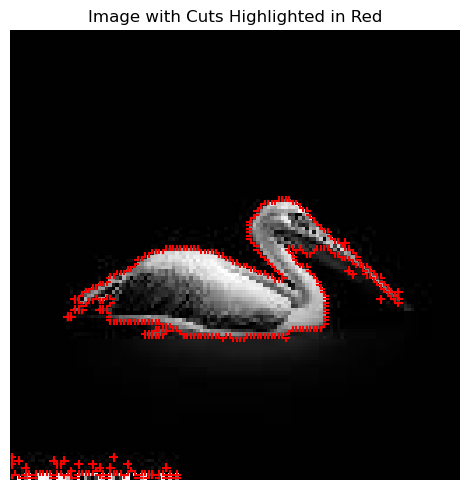

'\nNOTE:\noval-1.csv - Remove sigma argument from above, let it take the default from the class\nPic3.jpg (Pelican Image) - Remove sigma argument from above, let it take the default from the class\nbox.csv - Remove sigma argument from above, let it take the default from the class\ncircle_and_square.jpg - Sigma 5\nbottle - sigma 3.5\nflower.jpg - sigma 5\n'

In [ ]:
import numpy as np
import csv
import math
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import os
from PIL import Image
from collections import defaultdict as dd

import sys

# Need this to avoid RecursionError for dfs
sys.setrecursionlimit(100000)


class ImageSegmentation:
    """
    This class is used to segment an image into two regions using the max-flow min-cut algorithm.
    The image is represented as a graph where each pixel is a node and the edges are weighted by the similarity between the pixels.
    """

    model = None

    source = None
    sink = None
    image_array = None
    sigma = None
    fg_pixel = ()
    bg_pixel = ()
    image_arr_flat = None

    def __init__(self, filepath, sigma=None):
        """
        This function initializes the ImageSegmentation class with the image file path and the sigma value.
        It also loads the image and sets the background and foreground pixels.
        """
        self.load_image(filepath)
        if sigma is None:
            self.sigma = 0.01 * (np.max(self.image_array) - np.min(self.image_array))
        else:
            self.sigma = sigma

    def load_image(self, file_path):
        """
        This function loads the image from the file path and converts it to a greyscale 2D array.
        """

        if file_path.endswith(".jpg") or file_path.endswith(".jpeg"):
            image_array = np.array(Image.open(file_path).convert('L'))
            self.image_array = image_array
        else:
            # Load the image and convert it to a greyscale 2D array
            self.image_array = np.loadtxt(file_path, delimiter=',')

        self.bg_pixel = np.argmin(self.image_array.flatten())
        self.fg_pixel = np.argmax(self.image_array.flatten())
        self.image_arr_flat = self.image_array.flatten()

    def calc_similarity(self, pixel_i, pixel_j):
        """
        This function calculates the similarity between two pixels using the exponential function.
        """
        # return np.ceil(100 * np.exp(-((float(self.image_arr_flat[pixel_i]) - float(self.image_arr_flat[pixel_j])) ** 2) / (2 * self.sigma ** 2)))
        return 100 * np.exp(-((float(self.image_arr_flat[pixel_i]) - float(self.image_arr_flat[pixel_j])) ** 2) / (2 * self.sigma ** 2))

    def create_network(self):
        """
        This function creates the network for the image graph.
        Here we use a defaultdict to store the network as a dictionary of dictionaries so that we can handle files which can process large number of pixels.
        """
        rows, cols = self.image_array.shape
        size = rows * cols

        network = dd(dict)
        for x in range(size):
            r_num = x // cols
            c_num = x % cols
            near_pixels = []
            if r_num > 0:
                near_pixels.append(x - cols)
            if r_num < rows - 1:
                near_pixels.append(x + cols)
            if c_num > 0:
                near_pixels.append(x - 1)
            if c_num < cols - 1:
                near_pixels.append(x + 1)

            for pixel in near_pixels:
               network[x][pixel] = self.calc_similarity(x, pixel)

        # adding the source and sink (source --> background && foreground --> sink)
        network = self._add_terminal_nodes(network, size)
        return network

    def _add_terminal_nodes(self, network, size):
        """
        This function adds the source and sink nodes to the network.
        """
        network[size][self.bg_pixel] = np.inf # source
        network[self.fg_pixel][size+1] =  np.inf # sink
        self.source = size
        self.sink = size+1

        return network

    def solve_lp(self, network):
        """
        This function solves the linear program using the Gurobi library.
        """
        if None in [self.source, self.sink]:
            raise ValueError("Source and Sink not set")

        self.model = gp.Model()

        # Create variables for the flow on each edge
        flow = {(i, j): self.model.addVar(lb=0, ub=network[i][j], name=f'{i}-{j}')
                for i in network for j in network[i]}

        # Update the model to include these variables
        self.model.setObjective(gp.quicksum(flow[self.source, j] for j in network[self.source]), GRB.MAXIMIZE)

        # Add flow conservation constraints
        for i in network:
            if i != self.source and i != self.sink:
                inflow = gp.quicksum(flow[j, i] for j in network if i in network[j])
                outflow = gp.quicksum(flow[i, j] for j in network[i])
                self.model.addConstr(inflow == outflow)

        self.model.optimize()

        return flow

    def locate_cuts(self, network, flow):
        """
        This function locates the cuts in the network using a depth-first search recursive function.
        Note: This is why we set the recursion limit at the beginning of the script.
        """
        visited = set()

        def dfs(node):
            """
            This function performs a depth-first search to identify the cuts.
            """
            visited.add(node)
            for neighbor in network[node]:
                if neighbor not in visited and self.model.getVarByName(f'{node}-{neighbor}').X < network[node][neighbor] - 1e-6:
                    dfs(neighbor)

        dfs(self.source)

        # Identify cuts where one node is in visited and the other is not
        cuts = [(i, j) for i in visited for j in network[i] if j not in visited]

        return cuts


    def draw(self, cuts = []):
        """
        This function draws the image with the cuts highlighted in red.
        """
        plt.figure(figsize=(5, 5))
        plt.imshow(self.image_array, cmap='gray')
        rows, cols = self.image_array.shape
        if cuts:
            for i, j in cuts:
                ri, ci = divmod(i, cols)
                rj, cj = divmod(j, cols)
                plt.plot([ci, cj], [ri, rj], color='red', linewidth=1.5)
        plt.title("Image with Cuts Highlighted in Red")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


    def run_segmentation(self):
        """
        This function runs the image segmentation algorithm.
        """
        print("Creating Network...")
        network = self.create_network()
        print("Solving LP...")
        flow = self.solve_lp(network)
        print("Locating Cuts...")
        cuts = self.locate_cuts(network, flow)
        print("Drawing Image...")
        self.draw(cuts)

#Create an object and run the image segmentation algorithm

segmentation = ImageSegmentation('P.jpg')
segmentation.run_segmentation()

"""
NOTE:
oval-1.csv - Remove sigma argument from above, let it take the default from the class
Pic3.jpg (Pelican Image) - Remove sigma argument from above, let it take the default from the class
box.csv - Remove sigma argument from above, let it take the default from the class
circle_and_square.jpg - Sigma 5
bottle - sigma 3.5
flower.jpg - sigma 5
"""


Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 16384 rows, 65026 columns and 130050 nonzeros
Model fingerprint: 0x72db0c2f
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1574 rows and 7395 columns
Presolve time: 0.03s
Presolved: 14810 rows, 57631 columns, 115129 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 2.871e+04
 Factor NZ  : 2.932e+05 (roughly 30 MB of memory)
 Factor Ops : 8.187e+06 (less than 1 second per iteration)
 Threads    : 9

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual    

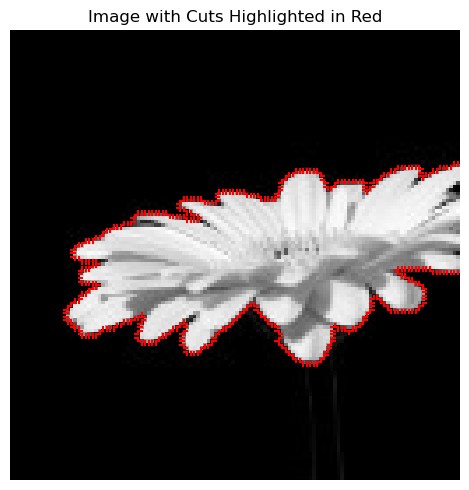

In [ ]:
segmentation = ImageSegmentation('sf.jpg')

segmentation.run_segmentation()


Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 16768 rows, 66556 columns and 133110 nonzeros
Model fingerprint: 0x659c1c19
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [6e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 383 rows and 1597 columns
Presolve time: 0.03s
Presolved: 16385 rows, 64959 columns, 129891 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 3.246e+04
 Factor NZ  : 4.098e+05 (roughly 36 MB of memory)
 Factor Ops : 2.014e+07 (less than 1 second per iteration)
 Threads    : 9

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     

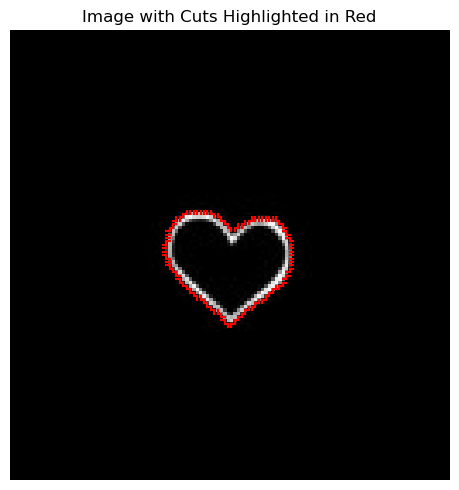

In [ ]:
segmentation = ImageSegmentation('h.jpg')

segmentation.run_segmentation()

Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 10880 rows, 43096 columns and 86190 nonzeros
Model fingerprint: 0x7fb6ad37
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1311 rows and 5853 columns
Presolve time: 0.02s
Presolved: 9569 rows, 37243 columns, 74363 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.853e+04
 Factor NZ  : 1.852e+05 (roughly 20 MB of memory)
 Factor Ops : 4.908e+06 (less than 1 second per iteration)
 Threads    : 9

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Co

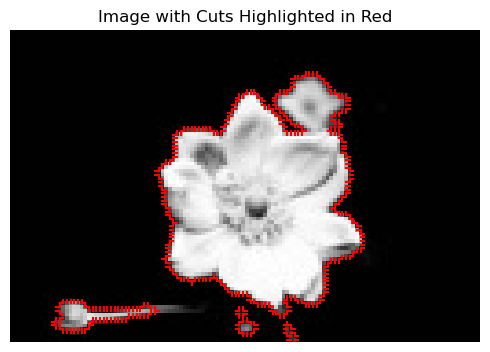

In [ ]:
segmentation = ImageSegmentation('f1.jpg')

segmentation.run_segmentation()

Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 14934 rows, 59248 columns and 118494 nonzeros
Model fingerprint: 0xda4f9047
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-322, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 976 rows and 4027 columns
Presolve time: 0.03s
Presolved: 13958 rows, 55221 columns, 110413 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 AA' NZ     : 2.759e+04
 Factor NZ  : 3.311e+05 (roughly 30 MB of memory)
 Factor Ops : 1.390e+07 (less than 1 second per iteration)
 Threads    : 9

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     

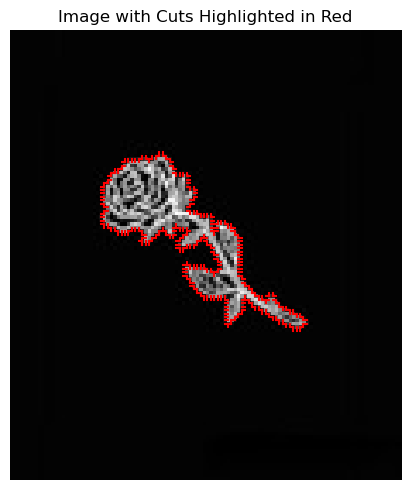

In [ ]:
segmentation = ImageSegmentation('f2.jpg')

segmentation.run_segmentation()

Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 12800 rows, 50746 columns and 101490 nonzeros
Model fingerprint: 0xef279918
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 2415 rows and 10653 columns
Presolve time: 0.03s
Presolved: 10385 rows, 40093 columns, 80051 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 1.994e+04
 Factor NZ  : 1.689e+05 (roughly 20 MB of memory)
 Factor Ops : 3.090e+06 (less than 1 second per iteration)
 Threads    : 9

Barrier performed 0 iterations in 0.09 seconds (0.08 work units)
Barrier solve interrupted - model solved by a

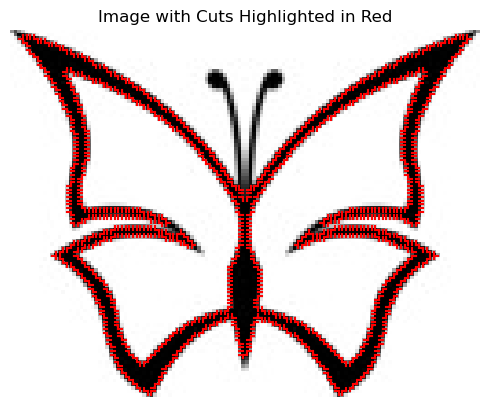

In [ ]:
segmentation = ImageSegmentation('m.jpg')

segmentation.run_segmentation()

Creating Network...
Solving LP...
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 17280 rows, 68596 columns and 137190 nonzeros
Model fingerprint: 0xb331e7dd
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e-319, 1e+02]
  RHS range        [0e+00, 0e+00]
Presolve removed 1877 rows and 8419 columns
Presolve time: 0.04s
Presolved: 15403 rows, 60177 columns, 120227 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier performed 0 iterations in 0.09 seconds (0.09 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Extra simplex iterations after uncrush: 495
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     714    2.5457

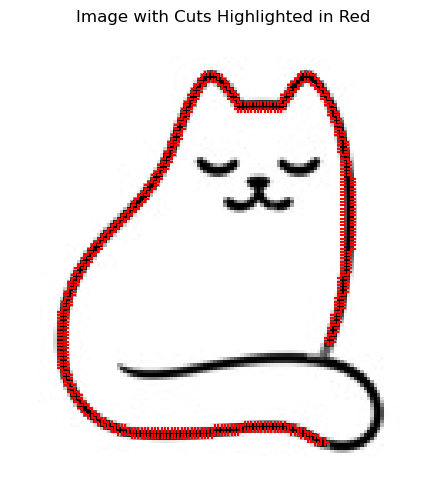

In [ ]:
segmentation = ImageSegmentation('cat.jpg')

segmentation.run_segmentation()